In [2]:
import numpy as np
from xrdc import xrdutils as xdu
from xrdc import simulation
import matplotlib.pyplot as plt

from siamese_xrd import train, datasets

def sample_peak_intensity():
    return np.random.uniform()

In [3]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [4]:
# FCC Ni definition
lparam_Ni = 3.52
s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(lparam_Ni), ["Ni"],
                                 [[0, 0, 0]])
s

Structure Summary
Lattice
    abc : 3.52 3.52 3.52
 angles : 90.0 90.0 90.0
 volume : 43.614208
      A : 3.52 0.0 0.0
      B : 0.0 3.52 0.0
      C : 0.0 0.0 3.52
PeriodicSite: Ni (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ni (0.0000, 1.7600, 1.7600) [0.0000, 0.5000, 0.5000]
PeriodicSite: Ni (1.7600, 0.0000, 1.7600) [0.5000, 0.0000, 0.5000]
PeriodicSite: Ni (1.7600, 1.7600, 0.0000) [0.5000, 0.5000, 0.0000]

In [5]:
gen = XRDCalculator("CuKa")
# gen = XRDCalculator(1.54)
pat = gen.get_pattern(s)
xdu.to_q(pat.x), pat.y

(array([3.09170346, 3.56999165, 5.04873061]),
 array([100.        ,  46.36686035,  26.67333336]))

Define the same structure directly from lattice vectors and unit cell

In [6]:
lat = Lattice(lparam_Ni * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
fcc_basis = np.array(((0, 0, 0), (.5, .5, 0), (.5, 0, .5), (0, .5, .5)))
struct = Structure(lat, ["Ni"] * len(fcc_basis), fcc_basis)

pat = gen.get_pattern(struct)
q, i = xdu.to_q(pat.x), pat.y

In [7]:
def xrd_from_geo(lattice, basis, species):
    lat = Lattice(lattice)
    struct = Structure(lat, species, basis)
    
    pat = gen.get_pattern(struct)
    return xdu.to_q(pat.x), pat.y

In [8]:
def distort_Ni(relative_c):
    return xrd_from_geo(lparam_Ni * np.array([[1, 0, 0], [0, 1, 0], [0, 0, relative_c]]), fcc_basis, ["Ni"] * 4)

In [14]:
def Ni_cubic_to_tetra(N, c_start, c_end, sigma = .01):
    """
    """
    cs =  np.linspace(c_start, c_end, N)
    res = []
    ordinal = []
    for c in cs:
        q, i = distort_Ni(c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

In [17]:
Ni_scan_peaks, Ni_scan = Ni_cubic_to_tetra(500, .9, 1.2)

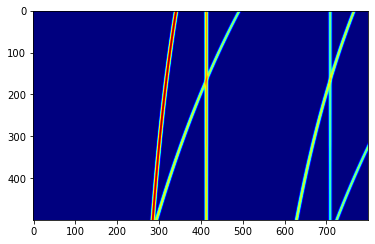

In [18]:
plt.imshow(np.log(Ni_scan + 1), cmap = 'jet')

In [16]:
Ni_scan_peaks

[array([[  3.21029795,   3.56999165,   3.96665739,   5.04873061,
           5.33659173],
        [100.        ,  34.94295695,  12.04225828,  10.05076829,
          16.66854099]]),
 array([[  3.20975259,   3.56999165,   3.96489169,   5.04873061,
           5.33527942],
        [100.        ,  34.92344539,  12.05483119,  10.04515611,
          16.67255187]]),
 array([[  3.20920788,   3.56999165,   3.96312755,   5.04873061,
           5.33396854],
        [100.        ,  34.90396578,  12.06741333,  10.03955312,
          16.67656804]]),
 array([[  3.20866379,   3.56999165,   3.96136499,   5.04873061,
           5.33265909],
        [100.        ,  34.88451805,  12.0800047 ,  10.0339593 ,
          16.68058948]]),
 array([[  3.20812034,   3.56999165,   3.95960399,   5.04873061,
           5.33135106],
        [100.        ,  34.86510213,  12.09260528,  10.02837463,
          16.68461616]]),
 array([[  3.20757752,   3.56999165,   3.95784456,   5.04873061,
           5.33004446],
        [10

In [11]:
distort_Ni(1.1)

(array([3.0009418 , 3.24544696, 3.56999165, 4.82470376, 5.04873061,
        5.48374904]),
 array([100.        ,  19.39412718,  28.09833433,  18.98544789,
          8.08202489,  12.29684462]))

In [15]:
from importlib import reload
reload(xdu)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [13]:
qq, ii = xdu.mk_pattern(i, q, .01, with_grid=True)

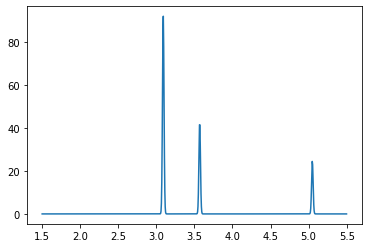

In [14]:
plt.plot(qq, ii)

## Cubic to tetragonal transition:

In [39]:
sigma = .03
q_cubic, i_cubic = distort_Ni(1)
cubic_patterns = np.vstack([xdu.mk_pattern(i_cubic, q_cubic, sigma, with_grid = False)
                           for _ in range(200)])

_, cubic_to_tetra_continuous = Ni_cubic_to_tetra(200, 1, 1.2, sigma = sigma)

In [45]:
from importlib import reload
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [32]:
q_tetra, i_tetra = distort_Ni(1.2)
cubic_to_tetra_twophase = simulation.transition(1, 1, (q, i), (q_tetra, i_tetra), 200, sigma = sigma,
                                                scale_type = 'scale')[::-1]

In [40]:
X = np.vstack((cubic_to_tetra_twophase, cubic_patterns, cubic_to_tetra_continuous))

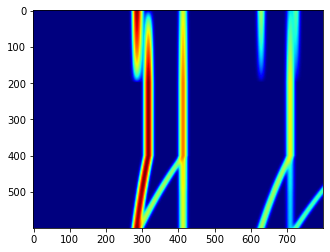

In [41]:
plt.imshow(np.log(1 + X), cmap = 'jet')

In [80]:
Ni_XX, Ni_YY = simulation.sample_transition(X, n_classes = 30, per_class = 200, scale_min = .8, scale_max = 1.2,
                                            scale_type = 'scale')


scale type: scale
q jitter: None
peak height variation True


In [79]:
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [74]:
Ni_X, Ni_Y = xdu.standardize_input(X, np.arange(len(X)) // 200)

In [60]:
Ni_XX.mean()

1.0000000000000007

In [81]:
prefix="Ni_cubic_to_tetra"
xdu.write_train_test("data/{}/".format(prefix), Ni_XX, Ni_YY,
                 Ni_XX,\
                 Ni_YY // 10)

In [84]:
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = 30, epochs = 200)

  0%|          | 0/37600 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


 16%|█▌        | 5828/37600 [01:14<04:09, 127.29it/s, epoch=30, train_loss=0.053, val_loss=0.0519] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff91cc4a0e0>
Traceback (most recent call last):
  File "/Users/ollie/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/Users/ollie/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/Users/ollie/anaconda3/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100%|██████████| 37600/37600 [07:36<00:00, 82.37it/s, epoch=199, train_loss=0.0338, val_loss=0.0341] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-*


Legend:

- blue: tetragonal to cubic (discontinuous)
- orange: cubic
- green: cubic to tetragonal (continuous)

siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-testing-set-embedding.png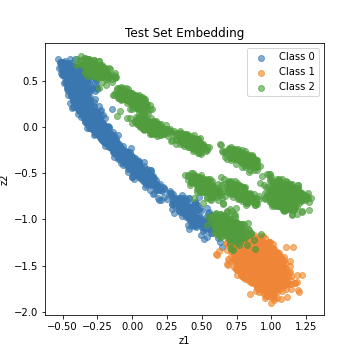